In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def resp_ratio(x):
    return sum(x == 1) / len(x)

# Yeast calling cards

In [3]:
out_dir = '~/Desktop/yeast_14tfs_cc/'

pred_df = pd.read_csv(out_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

cc_stats_df = pd.read_csv(out_dir + 'stats.csv.gz')
cc_stats_df = cc_stats_df.merge(rr_df, on='tf')

cc_stats_df

,cv,tf,auroc,auprc,label
0,0,YJR060W,0.668938,0.196084,0.071914
1,0,YLR451W,0.794302,0.230454,0.026887
2,1,YEL009C,0.598189,0.415220,0.309200
3,1,YIL036W,0.859790,0.134018,0.006479
4,2,YLR403W,0.627490,0.507672,0.403466
5,2,YPL248C,0.605988,0.180247,0.103661
6,3,YDR034C,0.728162,0.234175,0.066084
7,3,YKL038W,0.648870,0.108820,0.011824
8,4,YOR344C,0.686790,0.137404,0.035471
9,5,YPL075W,0.482613,0.049623,0.003239


# Yeast ChIP-exo

In [4]:
out_dir = '~/Desktop/yeast_19tfs_chipexo/'

pred_df = pd.read_csv(out_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

ce_stats_df = pd.read_csv(out_dir + 'stats.csv.gz')
ce_stats_df = ce_stats_df.merge(rr_df, on='tf')

ce_stats_df

,cv,tf,auroc,auprc,label
0,0,YBR239C,0.590494,0.067695,0.003239
1,0,YNL199C,0.754402,0.139749,0.019598
2,1,YBL103C,0.731723,0.231776,0.079527
3,1,YOR363C,0.596393,0.131409,0.006803
4,2,YGL162W,0.542553,0.019000,0.010852
5,2,YOR344C,0.742249,0.192911,0.035471
6,3,YJL089W,0.450373,0.030657,0.001620
7,3,YJR060W,0.669720,0.224889,0.071914
8,4,YMR280C,0.505598,0.053238,0.014253
9,4,YOL108C,0.635476,0.073007,0.028993


# Combine the best from CC and ChIP-exo

In [5]:
cc_stats_df['type'] = 'Calling Cards'
ce_stats_df['type'] = 'ChIP-exo'

stats_df = cc_stats_df.append(ce_stats_df, ignore_index=True)
combo_stats_df = pd.DataFrame()

for tf, subdf in stats_df.groupby('tf'):
    if subdf.shape[0] > 1:
        idx = subdf['auprc'].idxmax()
        combo_stats_df = combo_stats_df.append(subdf.loc[idx], ignore_index=True)
    else:
        combo_stats_df = combo_stats_df.append(subdf)

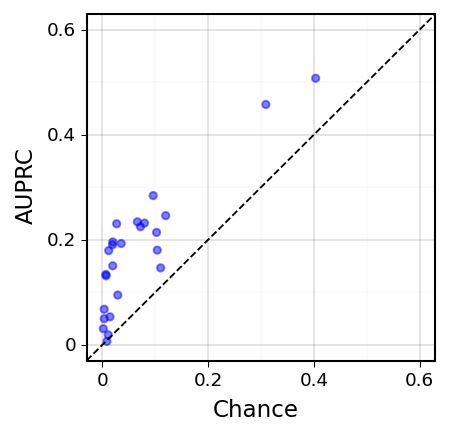

<ggplot: (7010083055)>

In [6]:
(
    ggplot(combo_stats_df, aes(x='label', y='auprc'))
    + geom_point(color='blue', alpha=.5)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + lims(x=[0, .6], y=[0, .6])
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

# Compare with biorvix figure
- biorxiv figure uses median AUPRC of each TF

In [7]:
brx_stats_df = pd.read_csv('/Users/kang/Google Drive/Pert_Response_Modeling/OUTPUT/Figures_suppl/yeast_auprcs.csv')
brx_stats_df = brx_stats_df.rename(columns={'TF': 'tf', 'AUPRC': 'auprc'})

brx_stats_df2 = pd.DataFrame()

for tf, subdf in brx_stats_df.groupby('tf'):
    if subdf.shape[0] > 1:
        idx = subdf['auprc'].idxmax()
        brx_stats_df2 = brx_stats_df2.append(subdf.loc[idx], ignore_index=True)
    else:
        brx_stats_df2 = brx_stats_df2.append(subdf)

tf count: 25 25
Ttest_indResult(statistic=-0.33493941970888, pvalue=0.7389221807557629)


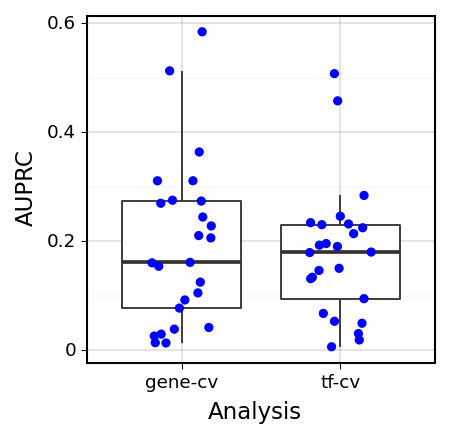

<ggplot: (7012300257)>

In [8]:
combo_stats_df['analysis'] = 'tf-cv'
brx_stats_df2['analysis'] = 'gene-cv'

print('tf count:', len(combo_stats_df), len(brx_stats_df2))
print(ss.ttest_ind(combo_stats_df['auprc'], brx_stats_df['auprc']))

plot_df = combo_stats_df.append(brx_stats_df2, ignore_index=True)

(
    ggplot(plot_df, aes(x='analysis', y='auprc'))
    + geom_boxplot(outlier_shape='')
    + geom_jitter(height=0, width=.2, color='blue')
    + labs(x='Analysis', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

# SHAP summed over genes for each TF - combine the best of binding sets

In [19]:
organism = 'yeast'
cc_dir = '~/Desktop/yeast_14tfs_cc/'

cc_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'Calling Cards', 'tf']
cc_sss_df = calculate_resp_and_unresp_signed_shap_sum(cc_dir, cc_tfs, organism)
cc_sss_df = cc_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
cc_sss_df = calculate_shap_net_influence(cc_sss_df)

chipexo_dir = '~/Desktop/yeast_19tfs_chipexo/'
ce_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'ChIP-exo', 'tf']
ce_sss_df = calculate_resp_and_unresp_signed_shap_sum(chipexo_dir, ce_tfs, organism)
ce_sss_df = ce_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
ce_sss_df = calculate_shap_net_influence(ce_sss_df)

sss_df = cc_sss_df.append(ce_sss_df, ignore_index=True)

25


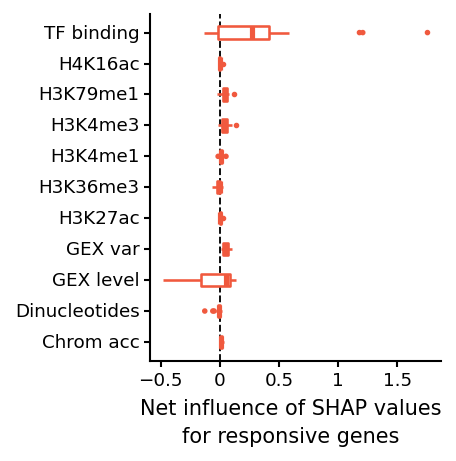

<ggplot: (-9223372029782827702)>

In [20]:
# Plot all models
plot_df = sss_df[(sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

18


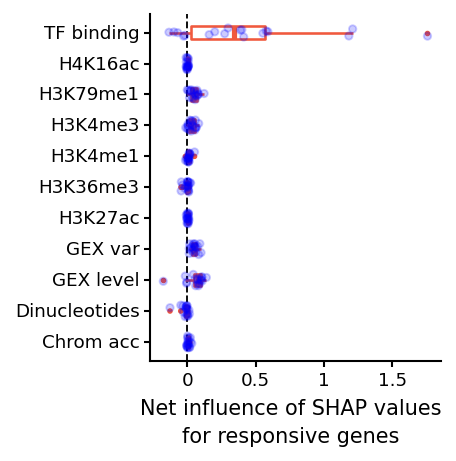

<ggplot: (-9223372029800113909)>

In [21]:
# Only plot models with AUPRC > 0.1
plot_df = sss_df[(sss_df['auprc'] > .1) & (sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

# SHAP - probability

In [9]:
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

In [10]:
organism = 'yeast'
cc_dir = '~/Desktop/yeast_14tfs_cc/'

cc_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'Calling Cards', 'tf']
cc_sss_df = calculate_resp_and_unresp_signed_shap_sum(cc_dir, cc_tfs, organism)
cc_sss_df = cc_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
cc_sss_df = calculate_shap_net_influence(cc_sss_df)

chipexo_dir = '~/Desktop/yeast_19tfs_chipexo/'
ce_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'ChIP-exo', 'tf']
ce_sss_df = calculate_resp_and_unresp_signed_shap_sum(chipexo_dir, ce_tfs, organism)
ce_sss_df = ce_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
ce_sss_df = calculate_shap_net_influence(ce_sss_df)

sss_df = cc_sss_df.append(ce_sss_df, ignore_index=True)

18


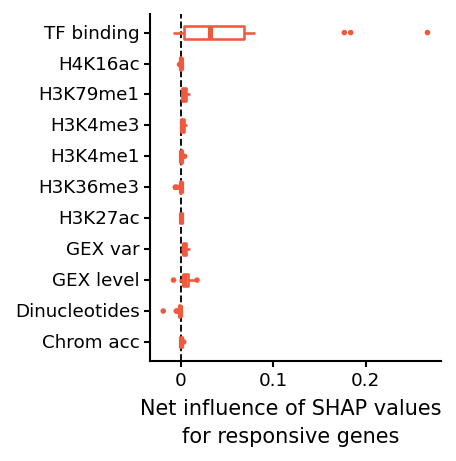

<ggplot: (-9223372029806914216)>

In [15]:
plot_df = sss_df[(sss_df['auprc'] > .1) & (sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .1)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

# SHAP - only CC

In [28]:
organism = 'yeast'
cc_dir = '~/Desktop/yeast_14tfs_cc.10_cv_folds/'

cc_tfs = np.loadtxt('/Users/kang/Desktop/TFPertRespExplainer/RESOURCES/Yeast_CallingCards_TFs.txt', dtype=str)
cc_sss_df = calculate_resp_and_unresp_signed_shap_sum(cc_dir, cc_tfs, organism)
cc_sss_df = cc_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
cc_sss_df = calculate_shap_net_influence(cc_sss_df)

14


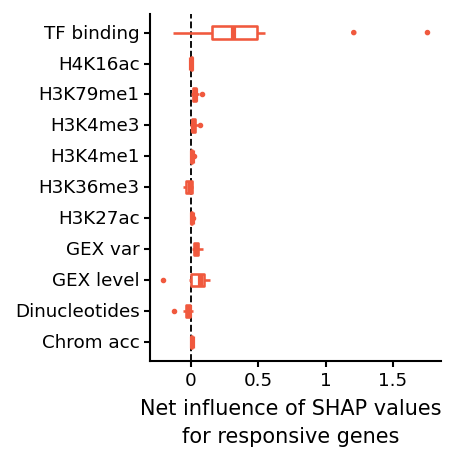

<ggplot: (7045394033)>

In [29]:
# Plot all models
plot_df = cc_sss_df[(cc_sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

12


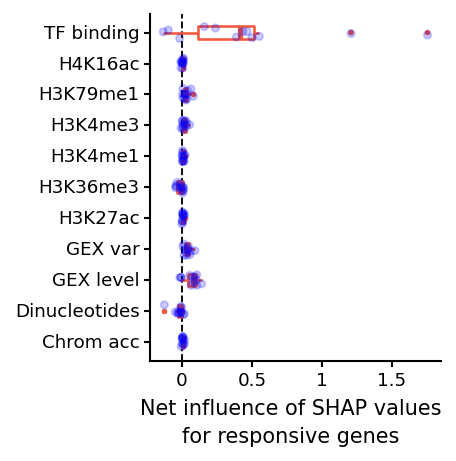

<ggplot: (7021627705)>

In [30]:
# Plot all models
plot_df = cc_sss_df[(cc_sss_df['auprc'] > .1) & (cc_sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

# SHAP - only ChIP-exo

In [24]:
organism = 'yeast'
ce_dir = '~/Desktop/yeast_19tfs_chipexo.10_cv_folds/'

ce_tfs = np.loadtxt('/Users/kang/Desktop/TFPertRespExplainer/RESOURCES/Yeast_ChIPexo_TFs.txt', dtype=str)
ce_sss_df = calculate_resp_and_unresp_signed_shap_sum(ce_dir, ce_tfs, organism)
ce_sss_df = ce_sss_df.merge(combo_stats_df[['tf', 'auprc']], on='tf', how='left')
ce_sss_df = calculate_shap_net_influence(ce_sss_df)

19


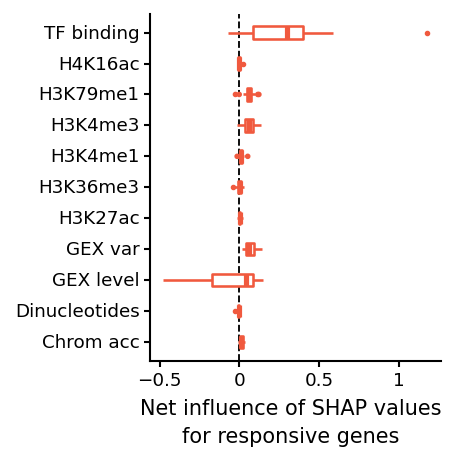

<ggplot: (-9223372029810518563)>

In [25]:
# Plot all models
plot_df = ce_sss_df[(ce_sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

12


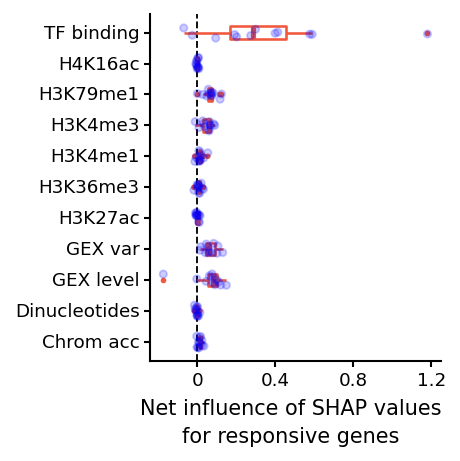

<ggplot: (7021400619)>

In [27]:
# Plot AUC > 0.1 models
plot_df = ce_sss_df[(ce_sss_df['auprc'] > .1) & (ce_sss_df['label_name'] == 'Responsive')]
print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, .6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

# SHAP plotted together

8


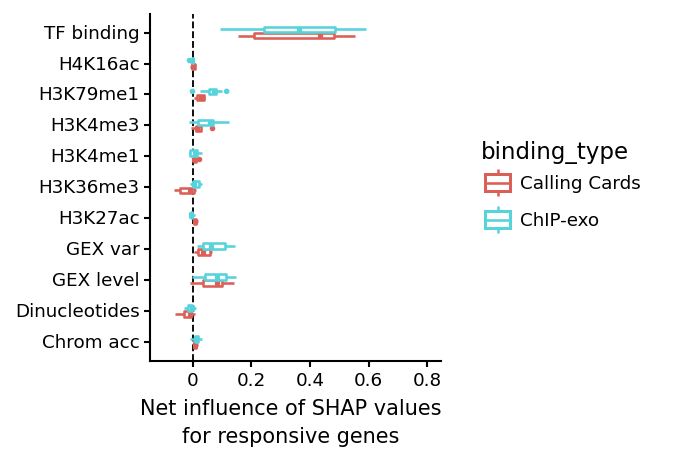

<ggplot: (7044164721)>

In [36]:
cc_sss_df['binding_type'] = 'Calling Cards'
ce_sss_df['binding_type'] = 'ChIP-exo'

plot_df = pd.concat([
    cc_sss_df[(cc_sss_df['label_name'] == 'Responsive')],
    ce_sss_df[(ce_sss_df['label_name'] == 'Responsive')]])

plot_df = plot_df[plot_df['tf'].isin(set(cc_sss_df['tf'].tolist()) & set(ce_sss_df['tf'].tolist()))]

print(len(plot_df['tf'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff', color='binding_type'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4)
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
    + ylim(-.1, .8)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

# SHAP summed over TFs for each gene - combine the best of binding sets

In [9]:
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

In [10]:
organism = 'yeast'
cc_dir = '~/Desktop/yeast_14tfs_cc/'

cc_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'Calling Cards', 'tf']
cc_sss_df = calculate_resp_and_unresp_signed_shap_sum(cc_dir, cc_tfs, organism, 'gene')
cc_sss_df = calculate_shap_net_influence(cc_sss_df, 'gene')

chipexo_dir = '~/Desktop/yeast_19tfs_chipexo/'
ce_tfs = combo_stats_df.loc[combo_stats_df['type'] == 'ChIP-exo', 'tf']
ce_sss_df = calculate_resp_and_unresp_signed_shap_sum(chipexo_dir, ce_tfs, organism, 'gene')
ce_sss_df = calculate_shap_net_influence(ce_sss_df, 'gene')

sss_df = cc_sss_df.append(ce_sss_df, ignore_index=True)

4688


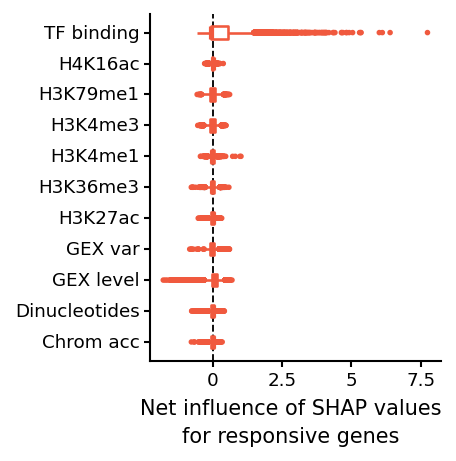

<ggplot: (7024545572)>

In [27]:
# Plot all models
plot_df = sss_df[(sss_df['label_name'] == 'Responsive')]
print(len(plot_df['gene'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

4688


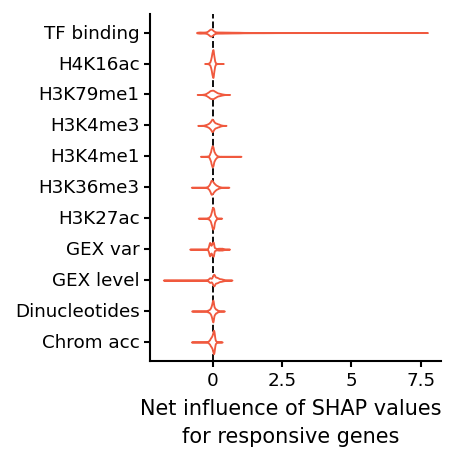

<ggplot: (-9223372029759728710)>

In [14]:
# Plot all models
plot_df = sss_df[(sss_df['label_name'] == 'Responsive')]
print(len(plot_df['gene'].unique()))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_violin(color=COLORS['orange'])
#     + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)
display(ax)

In [23]:
yeast_sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

plot_df['gene_com'] = plot_df['gene'].apply(lambda x: yeast_sys2com_dict[x] if x in yeast_sys2com_dict else x)
plot_df.loc[plot_df['feat_type_name'] == 'TF binding'].sort_values(by='shap_diff', ascending=False)[:30]

,feat_type_name,gene,label_name,shap_diff,gene_com
142267,TF binding,YJR138W,Responsive,7.738340,IML1
142960,TF binding,YMR197C,Responsive,6.392038,VTI1
143087,TF binding,YNL094W,Responsive,6.111895,APP1
141263,TF binding,YEL043W,Responsive,6.003304,S000000769
141356,TF binding,YER099C,Responsive,5.346990,PRS2
143067,TF binding,YNL063W,Responsive,5.327404,MTQ1
142832,TF binding,YML121W,Responsive,5.292517,GTR1
143719,TF binding,YPL206C,Responsive,5.041818,PGC1
141294,TF binding,YER017C,Responsive,4.917294,AFG3
141319,TF binding,YER052C,Responsive,4.830394,HOM3
